## Missing libraries?

Uncomment and run the cell for any of the libraries you are missing.

**NumPy**

In [3714]:
#!pip install numpy

**Pandas**

In [3715]:
#!pip install pandas

**Seaborn**

In [3716]:
#!pip install seaborn

**Matplotlib**

In [3717]:
#!pip install matplotlib

**IPython**

In [3718]:
#!pip install ipython

**Scikit-Learn**

In [3719]:
#!pip install scikit-learn

## Credit Card Fraud Kaggle Project

Logistic Regression and a random forest model to predict fraudulent transactions on credit card data.

This notebook is a scikit-learn conversion of the original statsmodels implementation.

In [3720]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, classification_report, average_precision_score, precision_recall_curve, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

# Keep the same random state and parameters as the original
rState = 42
test_size = 0.31
prediction_threshold = 0.1275

In [3721]:
#Load the dataset.
df = pd.read_csv("fraud_data.csv")

In [3722]:
df.head() #Display the first few rows of the dataset to understand its structure and contents.

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


In [3723]:
print(df.info()) #Display the information about the dataset, including the number of rows, columns, and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  object 
dtypes:

In [3724]:
#Value counts show that the data is imbalanced. Which is what would be expected for fraudulent activity.
df['is_fraud'].value_counts() #0 is not a fraud, 1 is a fraud.

is_fraud
0                         12600
1                          1844
1"2020-12-24 16:56:24"        1
0"2019-01-01 00:00:44"        1
Name: count, dtype: int64

In [3725]:
#Dropping the two observations that are not a 0 or 1 but also have a timestamp.
df = df[df['is_fraud'].isin(['1', '0'])]

In [3726]:
#This is not from baseline model. Remove transaction number, city, state, job, and merchant columns.
df.drop(columns=['trans_num', 'city', 'state', 'job', 'merchant'], inplace=True)

In [3727]:
df.head() #Display the first few rows of the dataset after dropping the specified columns.

,trans_date_trans_time,category,amt,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,grocery_net,14.37,64.7556,-165.6723,145,09-11-1939,65.654142,-164.722603,1
1,04-01-2019 15:06,shopping_net,966.11,64.7556,-165.6723,145,09-11-1939,65.468863,-165.473127,1
2,04-01-2019 22:37,misc_pos,49.61,64.7556,-165.6723,145,09-11-1939,65.347667,-165.914542,1
3,04-01-2019 23:06,grocery_pos,295.26,64.7556,-165.6723,145,09-11-1939,64.445035,-166.080207,1
4,04-01-2019 23:59,health_fitness,18.17,64.7556,-165.6723,145,09-11-1939,65.447094,-165.446843,1


#### Feature Engineering

In [3728]:
#Creating an age category.
df['dob'][0]

df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format="%d-%m-%Y %H:%M") #Convert the date into a datetime object.

#Age of the person when they made the transaction.
df['age'] = (df['trans_date_trans_time'] - pd.to_datetime(df['dob'], format="%d-%m-%Y")).dt.days // 365 #Convert the date into years for age.

# Extracting the time of the day
df['time_of_day'] = df['trans_date_trans_time'].dt.strftime('%H:%M')

# Hour of Day
df['hour'] = df['trans_date_trans_time'].dt.hour

#Extracting day of the week.
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()

#Create a new measure of the distance between lat and long and merchant lat and long
## Define the Haversine function
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371.0  # Radius of Earth in kilometers
    distance = r * c
    return distance
    
## Apply Haversine function row-wise
df['distance_km'] = df.apply(
    lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']),
    axis=1
)

In [3729]:
df.head()

,trans_date_trans_time,category,amt,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,age,time_of_day,hour,day_of_week,distance_km
0,2019-01-04 00:58:00,grocery_net,14.37,64.7556,-165.6723,145,09-11-1939,65.654142,-164.722603,1,79,00:58,0,Friday,109.285552
1,2019-01-04 15:06:00,shopping_net,966.11,64.7556,-165.6723,145,09-11-1939,65.468863,-165.473127,1,79,15:06,15,Friday,79.856896
2,2019-01-04 22:37:00,misc_pos,49.61,64.7556,-165.6723,145,09-11-1939,65.347667,-165.914542,1,79,22:37,22,Friday,66.807915
3,2019-01-04 23:06:00,grocery_pos,295.26,64.7556,-165.6723,145,09-11-1939,64.445035,-166.080207,1,79,23:06,23,Friday,39.636227
4,2019-01-04 23:59:00,health_fitness,18.17,64.7556,-165.6723,145,09-11-1939,65.447094,-165.446843,1,79,23:59,23,Friday,77.611529


In [3730]:
#Transforming specific data into categorical variables.
df['category'] = df['category'].astype('category')
df['day_of_week'] = df['day_of_week'].astype('category')
df['hour'] = df['hour'].astype('category')
df['is_fraud'] = df['is_fraud'].astype(int)

In [3731]:
#Checking the variable types.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14444 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trans_date_trans_time  14444 non-null  datetime64[ns]
 1   category               14444 non-null  category      
 2   amt                    14444 non-null  float64       
 3   lat                    14444 non-null  float64       
 4   long                   14444 non-null  float64       
 5   city_pop               14444 non-null  int64         
 6   dob                    14444 non-null  object        
 7   merch_lat              14444 non-null  float64       
 8   merch_long             14444 non-null  float64       
 9   is_fraud               14444 non-null  int64         
 10  age                    14444 non-null  int64         
 11  time_of_day            14444 non-null  object        
 12  hour                   14444 non-null  category      
 13  day_of

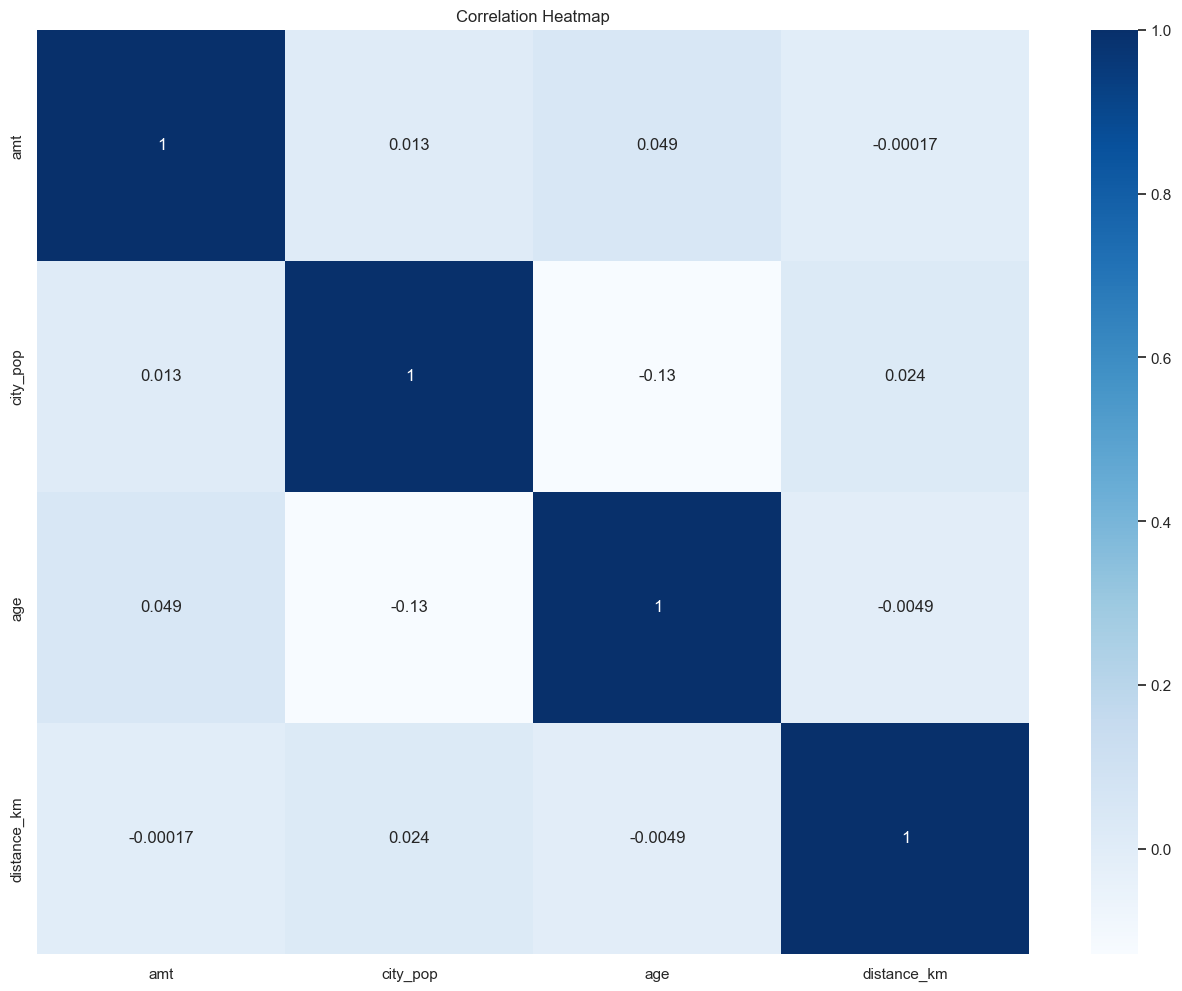

In [3732]:
# The correlation matrix shows that the numeric data is not correlated.
quantdata = df[["amt", "city_pop", "age", "distance_km"]]
corr_matrix = quantdata.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

In [3733]:
#No NAs in dataset before data modeling.
nan_counts = df.isna().sum()
print(nan_counts)

trans_date_trans_time    0
category                 0
amt                      0
lat                      0
long                     0
city_pop                 0
dob                      0
merch_lat                0
merch_long               0
is_fraud                 0
age                      0
time_of_day              0
hour                     0
day_of_week              0
distance_km              0
dtype: int64


### Logistic Regression to Predict Fraud (scikit-learn version)

In [3734]:
# Split into Train and Test - use the same random state as original
train_data, test_data = train_test_split(df, test_size=test_size, random_state=rState)

In [3735]:
# Original statsmodels formula: "is_fraud ~ age + amt + hour + category"
# For most similar results to statsmodels, use one-hot encoding without dropping first level

# Extract feature columns - these match the ones from the original formula
X_features = ['age', 'amt', 'hour', 'category']

# Create a copy of our data for scikit-learn's model
# Had to use chatgpt to figure out how to get the categorical variables into the model for help in converting statsmodels to scikit.
# Using get_dummies with drop_first=False to most closely match statsmodels treatment of categorical vars.
X_train = pd.get_dummies(train_data[X_features], columns=['hour', 'category'], drop_first=False)
y_train = train_data['is_fraud']
X_test = pd.get_dummies(test_data[X_features], columns=['hour', 'category'], drop_first=False)
y_test = test_data['is_fraud']

# Initialize the logistic regression model without class_weight to match original
# Use same max_iter and random_state as original
log_reg = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear')
log_reg.fit(X_train, y_train)

coefficients_map = {
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}

# Display the coefficients
coefficients = pd.DataFrame(coefficients_map).sort_values('Coefficient', ascending=False)

print("Model Coefficients (Top 10):")
display(coefficients.head(10))

Model Coefficients (Top 10):


,Feature,Coefficient
25,hour_23,2.701289
24,hour_22,2.570476
28,category_gas_transport,1.382015
30,category_grocery_pos,1.220991
2,hour_0,1.154301
3,hour_1,1.149274
5,hour_3,1.005823
4,hour_2,0.999878
29,category_grocery_net,0.737507
35,category_misc_pos,0.131110


In [3736]:
# Ensure test data has same columns as training data
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[X_train.columns]

# Predict Probabilities
preds = log_reg.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)

# Add predictions and agreement columns to the test dataframe
test_data['prob'] = preds
test_data['prediction'] = np.where(test_data['prob'] > prediction_threshold, 1, 0)
test_data['agree'] = np.where(test_data['prediction'] == test_data['is_fraud'], 1, 0)

# Calculate naive accuracy, model accuracy, and AUPRC - same as original
naive_accuracy = 1 - test_data['is_fraud'].sum() / len(test_data)
accuracy = test_data['agree'].sum() / len(test_data)
auprc = average_precision_score(test_data['is_fraud'], preds)

# Identify Disagreements
disagree = test_data[test_data['agree'] == 0]

# Display Results
print(f"Naive Accuracy: {naive_accuracy}")
print(f"Model Accuracy: {accuracy}")
print(f"AUPRC: {auprc}")
print(f"Number of test samples: {len(test_data)}")

Naive Accuracy: 0.8702545779365789
Model Accuracy: 0.8624385886556498
AUPRC: 0.8109416874446325
Number of test samples: 4478


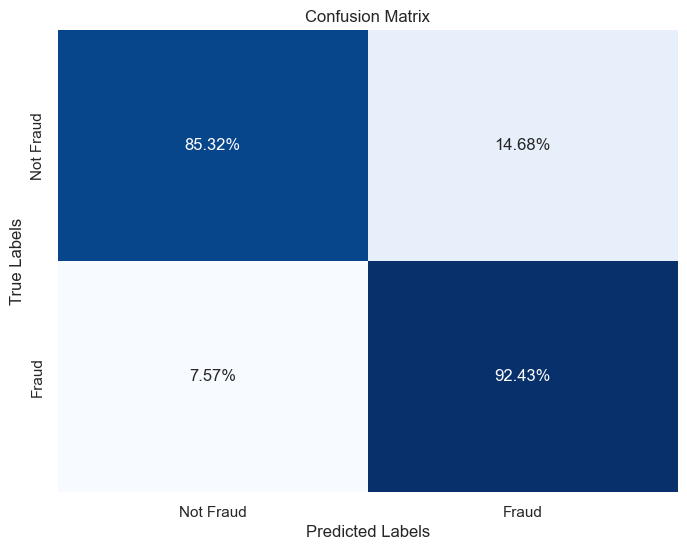

-----------------------------------------------------------------
                    Classification Report
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3897
           1       0.48      0.92      0.64       581

    accuracy                           0.86      4478
   macro avg       0.74      0.89      0.78      4478
weighted avg       0.92      0.86      0.88      4478



In [3737]:
# Compute the confusion matrix - same as original
cm = confusion_matrix(test_data['is_fraud'], test_data['prediction'], normalize="true")

# Define labels for the classes
labels = ["Not Fraud", "Fraud"]

# Create confusion matrix plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("-" * 65)
print(' ' * 20 + "Classification Report")
print(classification_report(test_data['is_fraud'], test_data['prediction']))

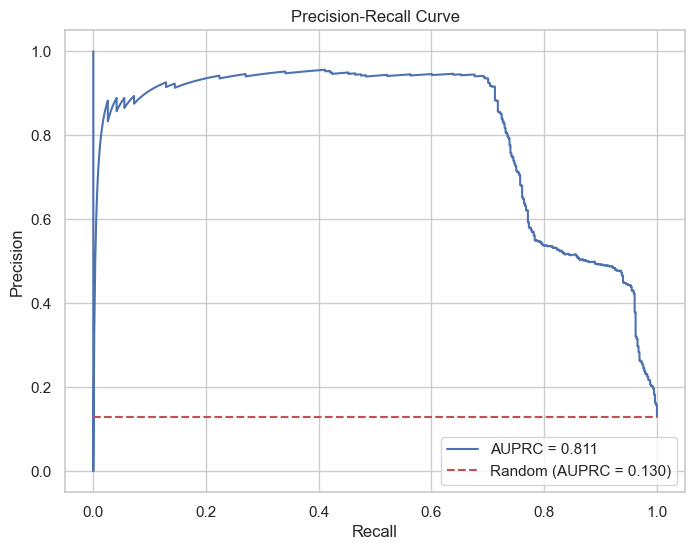

AUPRC: 0.8109


In [3738]:
# Plot precision-recall curve
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_data['is_fraud'], test_data['prob'])

# Calculate area under precision-recall curve
auprc = average_precision_score(test_data['is_fraud'], test_data['prob'])

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'AUPRC = {auprc:.3f}')

# Add a line for random performance (class imbalance ratio)
random = len(test_data[test_data['is_fraud'] == 1]) / len(test_data)
plt.plot([0, 1], [random, random], 'r--', label=f'Random (AUPRC = {random:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Print the AUPRC score
print(f"AUPRC: {auprc:.4f}")

# Learning Curve

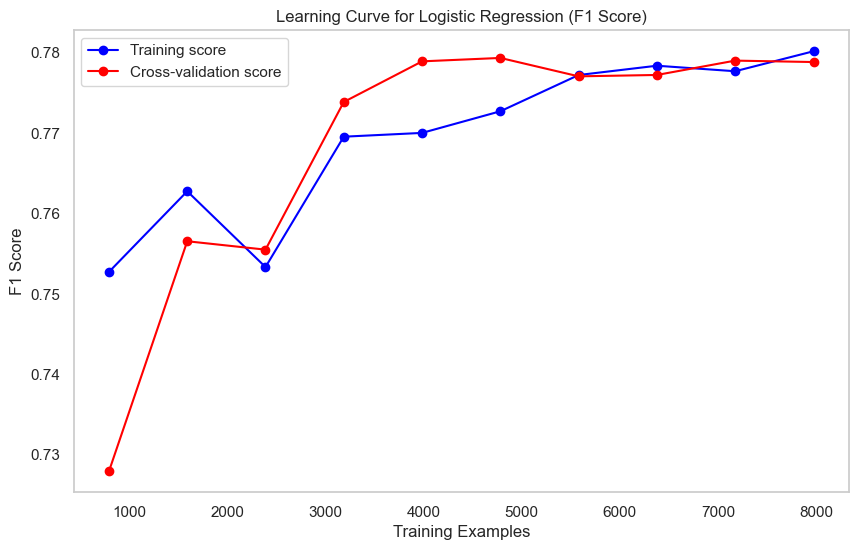

Training examples	Training Score	Validation Score
797		0.7527		0.7280
1594		0.7628		0.7566
2391		0.7533		0.7555
3188		0.7695		0.7739
3986		0.7700		0.7789
4783		0.7727		0.7793
5580		0.7772		0.7771
6377		0.7784		0.7772
7174		0.7777		0.7790
7972		0.7802		0.7788


In [3739]:
# Use the same scikit-learn model as above for consistency
sklearn_log_reg = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear')

# Calculate learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    sklearn_log_reg, X_train, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),  # Train on 10%, 20%, ..., 100% of data
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Using F1 score for imbalanced data
    n_jobs=-1  # Use all available cores
)

# Calculate mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve for Logistic Regression (F1 Score)")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.grid()

plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, valid_mean, 'o-', color="red", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Print numeric results
print("Training examples\tTraining Score\tValidation Score")
for i in range(len(train_sizes)):
    print(f"{train_sizes[i]:.0f}\t\t{train_mean[i]:.4f}\t\t{valid_mean[i]:.4f}")

# L2 Regularization


In [3740]:
# Test different C values (inverse of regularization strength)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results = []

for C in C_values:
    log_reg_l2 = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear', C=C, penalty='l2')
    log_reg_l2.fit(X_train, y_train)
    
    y_prob_l2 = log_reg_l2.predict_proba(X_test)[:, 1]
    y_pred_l2 = (y_prob_l2 >= prediction_threshold).astype(int)
    
    results.append({
        'C': C,
        'AUPRC': average_precision_score(y_test, y_prob_l2),
        'F1': f1_score(y_test, y_pred_l2),
        'Recall': recall_score(y_test, y_pred_l2),
        'Precision': precision_score(y_test, y_pred_l2)

    })

results_df = pd.DataFrame(results)
print("L2 Regularization Results:")
print(results_df)
best_C = results_df.loc[results_df["AUPRC"].idxmax(), "C"]
print(f"Best C value: {best_C}")

L2 Regularization Results:
         C     AUPRC        F1    Recall  Precision
0    0.001  0.630719  0.426262  0.748709   0.297945
1    0.010  0.731779  0.578211  0.817556   0.447269
2    0.100  0.800056  0.628872  0.925990   0.476106
3    1.000  0.810942  0.635503  0.924269   0.484220
4   10.000  0.812905  0.636310  0.925990   0.484685
5  100.000  0.813237  0.636310  0.925990   0.484685
Best C value: 100.0


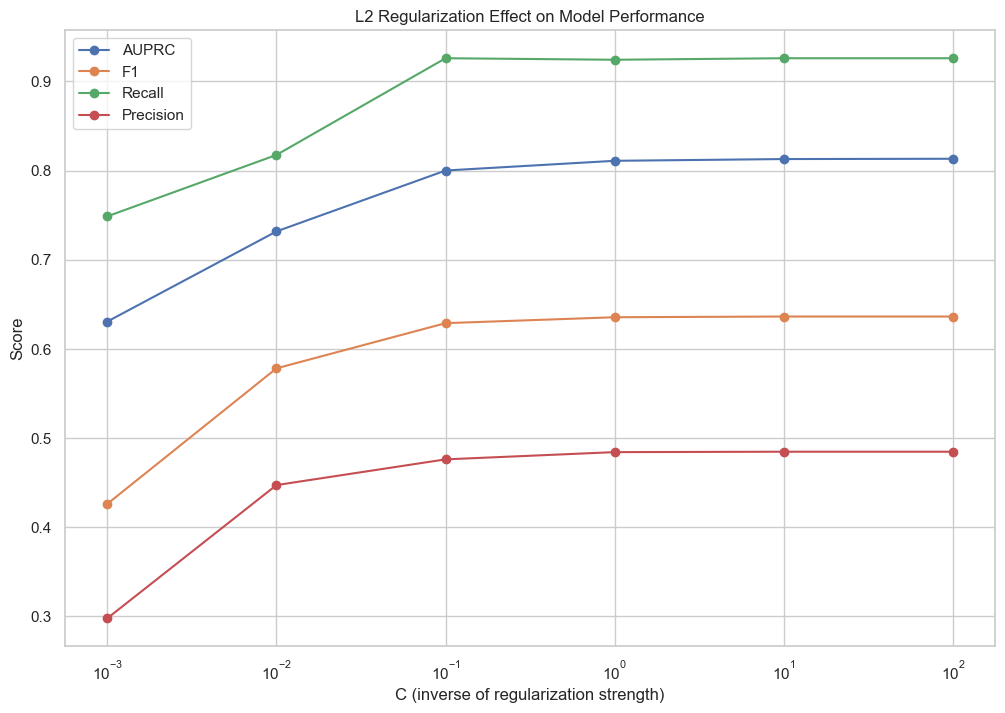

In [3741]:
#Plot C vs Metrics
plt.figure(figsize=(12, 8))
plt.semilogx(results_df['C'], results_df['AUPRC'], 'o-', label='AUPRC')
plt.semilogx(results_df['C'], results_df['F1'], 'o-', label='F1')
plt.semilogx(results_df['C'], results_df['Recall'], 'o-', label='Recall')
plt.semilogx(results_df['C'], results_df['Precision'], 'o-', label='Precision')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Score')
plt.title('L2 Regularization Effect on Model Performance')
plt.legend()
plt.grid(True)
plt.show()

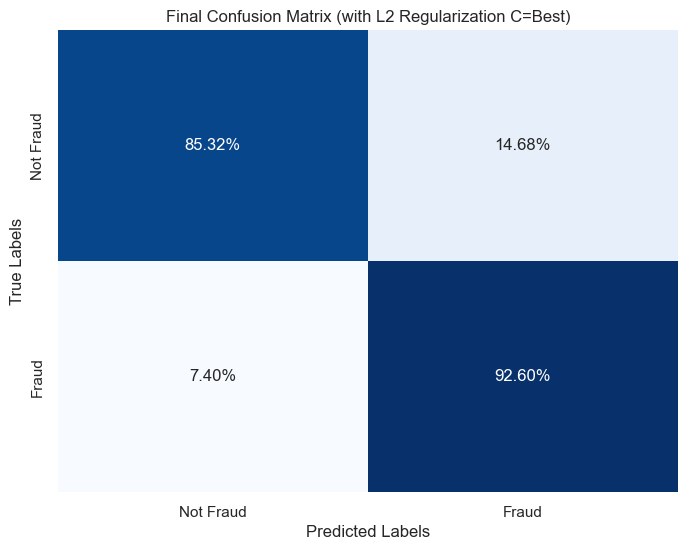

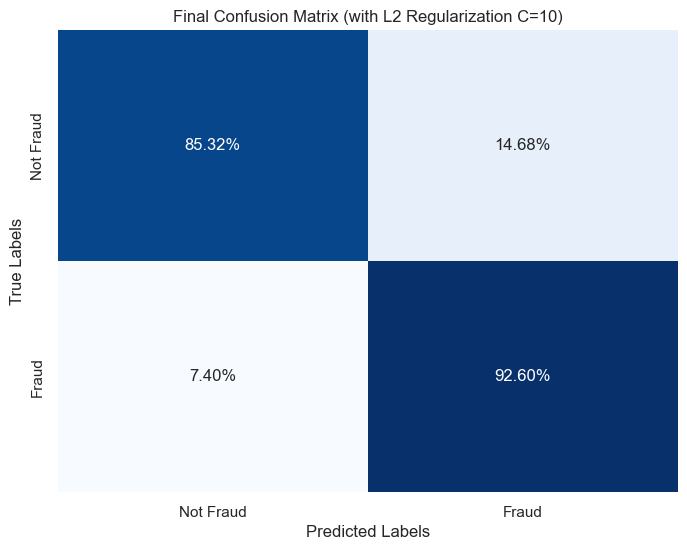

In [3742]:
#Create a model with best C value and a model with C=10 to compare.
log_reg_best = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear', C=best_C, penalty='l2')
log_reg_second = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear', C=10, penalty='l2')
log_reg_best.fit(X_train, y_train)
log_reg_second.fit(X_train, y_train)

y_prob_best = log_reg_best.predict_proba(X_test)[:, 1]
y_pred_best = (y_prob_best > prediction_threshold).astype(int)
y_prob_second = log_reg_second.predict_proba(X_test)[:, 1]
y_pred_second = (y_prob_second > prediction_threshold).astype(int)


final_cm = confusion_matrix(y_test, y_pred_best, normalize="true")
plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Final Confusion Matrix (with L2 Regularization C=Best)')
plt.show()

final_cm = confusion_matrix(y_test, y_pred_second, normalize="true")
plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Final Confusion Matrix (with L2 Regularization C=10)')
plt.show()

In [3743]:
# Sample data setup (replace with your actual dataframe and columns)
# df = your_data_frame  # This should already be defined in your code
# X_features = your_feature_columns  # Your list of feature column names

# Apply get_dummies to categorical columns before splitting
df_copy = pd.get_dummies(df, columns=['hour', 'category'], drop_first=False)

test_sizes = [0.1, 0.2, 0.3, 0.31, .35, .4]  # Different test sizes
thresholds = [0.1, 0.1275, .15, 0.2, 0.3, 0.5, 0.7]  # Different thresholds

# Initialize the cross-validation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store the results
results = []

# For each test size and threshold combination
for test_size in test_sizes:
    for threshold in thresholds:
        
        # For each fold, split into training and testing sets
        for train_idx, val_idx in cv.split(df_copy[["age", "amt"]], df_copy['is_fraud']):
            # Get the training and validation data
            X_train, X_val = df_copy.iloc[train_idx][["age", "amt"]], df_copy.iloc[val_idx][["age", "amt"]]
            y_train, y_val = df_copy.iloc[train_idx]['is_fraud'], df_copy.iloc[val_idx]['is_fraud']

            # Further split the training set into a train and validation set
            X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train, y_train, 
                                                                                 test_size=test_size, 
                                                                                 stratify=y_train, 
                                                                                 random_state=42)

            # Train the logistic regression model
            model = LogisticRegression(max_iter=1000, random_state=rState, solver='liblinear', C=100, penalty='l2')

            model.fit(X_train_part, y_train_part)

            # Get probabilities for the positive class (fraud in this case)
            probs = model.predict_proba(X_val_part)[:, 1]  # Probabilities for positive class

            # Apply threshold to get binary predictions
            preds = (probs >= threshold).astype(int)

            # Evaluate performance
            recall_val = recall_score(y_val_part, preds)
            precision_val = precision_score(y_val_part, preds)
            auprc_val = average_precision_score(y_val_part, probs)

            # Store the results
            results.append({
                "Test Size": test_size,
                "Threshold": threshold,
                "Recall": recall_val,
                "Precision": precision_val,
                "AUPRC": auprc_val
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(results_df)


     Test Size  Threshold    Recall  Precision     AUPRC
0          0.1        0.1  0.756757   0.530806  0.670966
1          0.1        0.1  0.790541   0.544186  0.743597
2          0.1        0.1  0.750000   0.531100  0.711540
3          0.1        0.1  0.790541   0.534247  0.692901
4          0.1        0.1  0.729730   0.502326  0.676839
..         ...        ...       ...        ...       ...
205        0.4        0.7  0.444068   0.903448  0.667846
206        0.4        0.7  0.462712   0.913043  0.701331
207        0.4        0.7  0.469492   0.929530  0.687516
208        0.4        0.7  0.479661   0.918831  0.693839
209        0.4        0.7  0.467797   0.907895  0.712924

[210 rows x 5 columns]


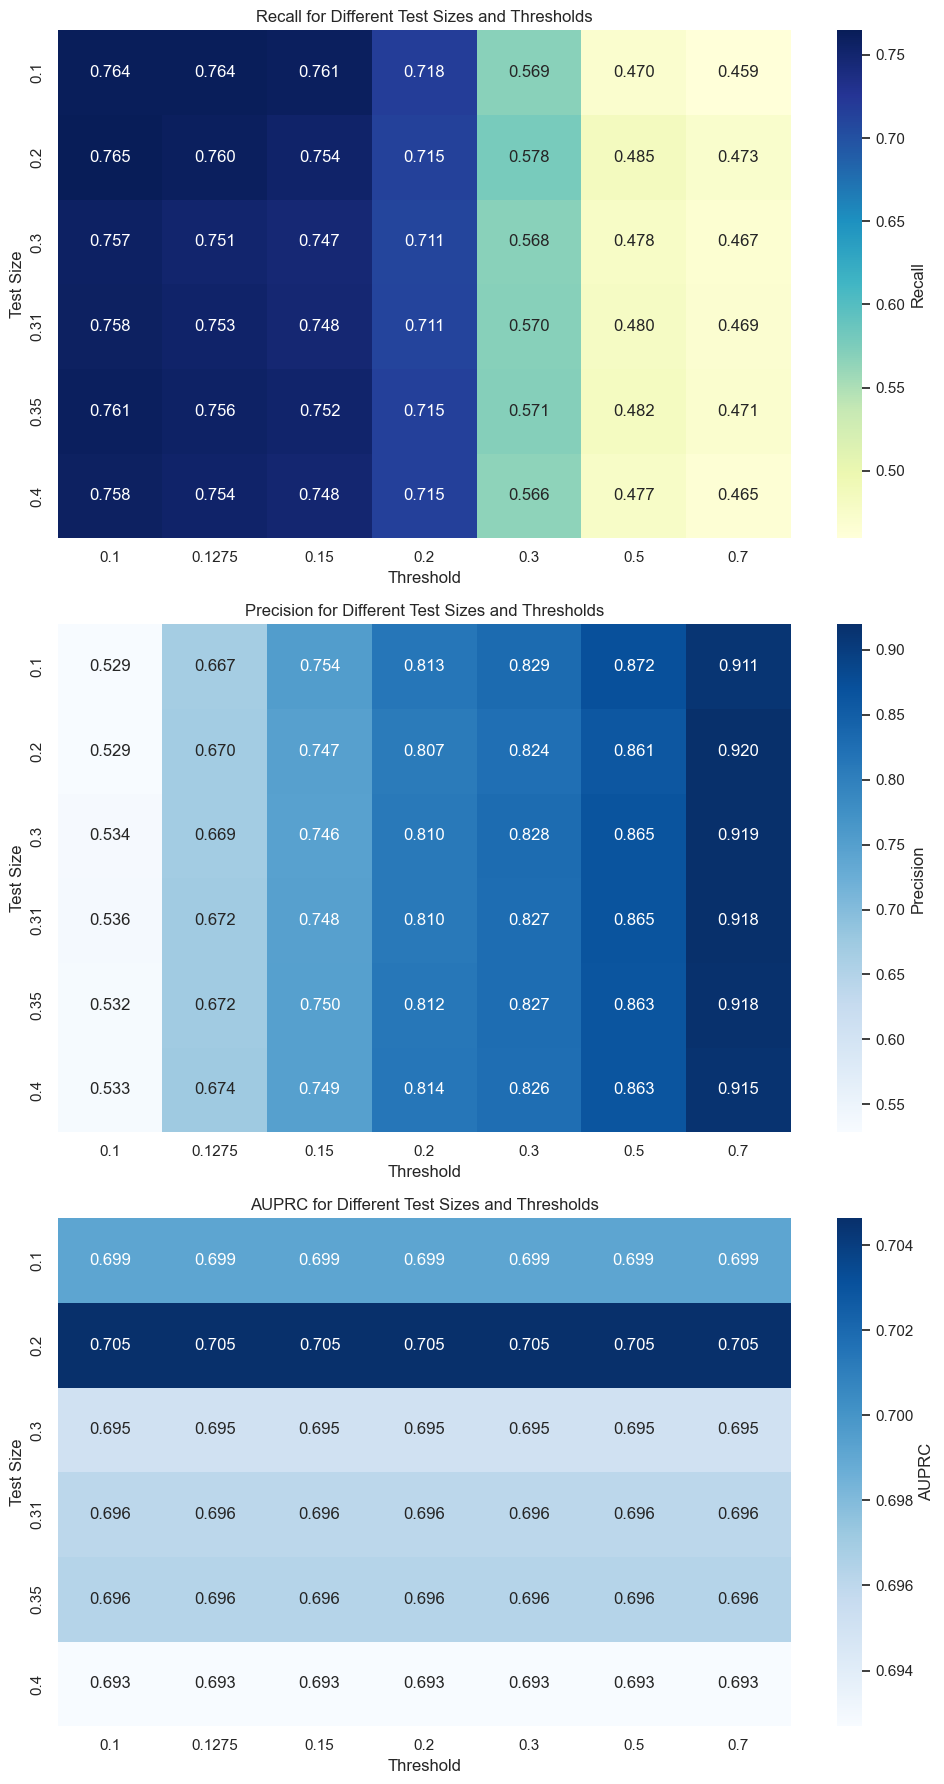

In [3744]:
sns.set_theme(style="whitegrid")

# Create a figure with subplots (3 rows for each metric)
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Pivot the results for each metric
results_pivot_recall = results_df.pivot_table(index='Test Size', columns='Threshold', values='Recall')
results_pivot_precision = results_df.pivot_table(index='Test Size', columns='Threshold', values='Precision')
results_pivot_auprc = results_df.pivot_table(index='Test Size', columns='Threshold', values='AUPRC')

# Plot Recall
sns.heatmap(results_pivot_recall, annot=True, cmap="YlGnBu", fmt=".3f", cbar_kws={'label': 'Recall'}, ax=axes[0])
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Test Size')
axes[0].set_title('Recall for Different Test Sizes and Thresholds')

# Plot Precision
sns.heatmap(results_pivot_precision, annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'Precision'}, ax=axes[1])
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Test Size')
axes[1].set_title('Precision for Different Test Sizes and Thresholds')

# Plot AUPRC
sns.heatmap(results_pivot_auprc, annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'AUPRC'}, ax=axes[2])
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Test Size')
axes[2].set_title('AUPRC for Different Test Sizes and Thresholds')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### Random Forest for Fraud Prediction

This model is not used, but is here from the baseline.

In [3745]:
# Creating a new dataframe for the Random Forest
dftree = df[['is_fraud', 'category', 'amt', 'city_pop', 'age', 'hour', 'day_of_week', 'distance_km']].copy()

# Initialize the label encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
dftree['category'] = le.fit_transform(dftree['category'])
dftree['day_of_week'] = le.fit_transform(dftree['day_of_week'])
dftree['hour'] = le.fit_transform(dftree['hour'])

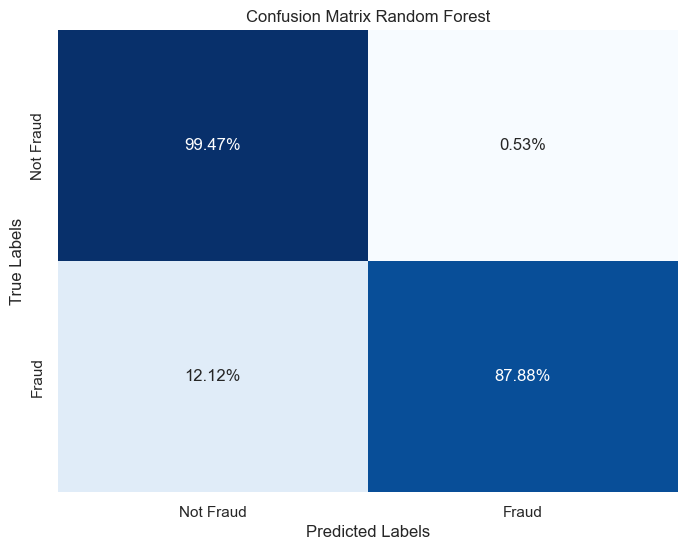

############################################################
                     Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3781
           1       0.96      0.88      0.92       553

    accuracy                           0.98      4334
   macro avg       0.97      0.94      0.95      4334
weighted avg       0.98      0.98      0.98      4334



In [3746]:
# Splitting the dataset into train and test sets
X = dftree.drop(columns=['is_fraud'])  # Features
y = dftree['is_fraud']                # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize Random Forest with class weight to handle imbalanced classes
# Use class_weight='balanced' to match the original code
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # For AUC-ROC score

# Compute the confusion matrix
cm1 = confusion_matrix(y_test, y_pred, normalize="true") #Normalized confusion matrix.
# Define labels for the classes
labels = ["Not Fraud", "Fraud"]
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Random Forest')
plt.show()

print("#" * 60)
print(" " * 20, "Classification Report")
print(classification_report(y_test, y_pred))

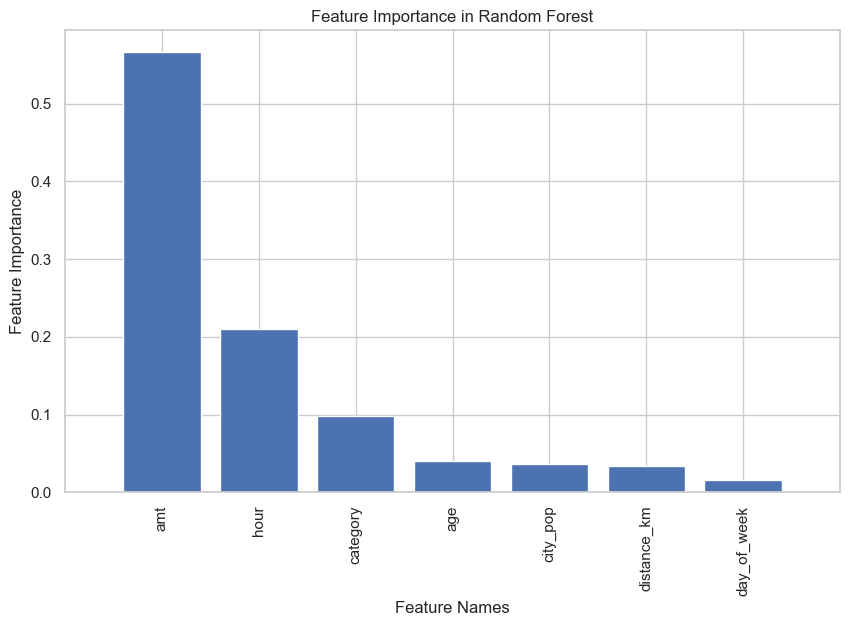

In [3747]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.xlabel("Feature Names")
plt.ylabel("Feature Importance")
plt.title("Feature Importance in Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [3748]:
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


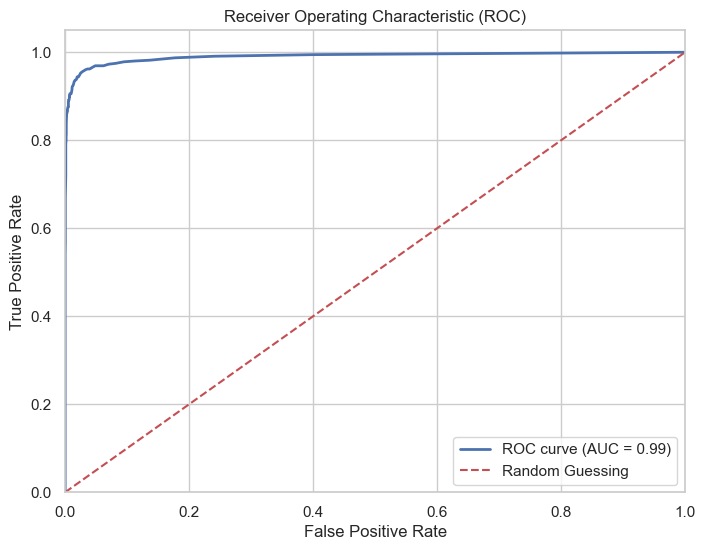

In [3749]:
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [3750]:
# Perform 5-fold cross-validation
scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')

# Print each fold's AUC score and the average
print("AUC scores for each fold:", scores)
print("Mean AUC score:", scores.mean())

AUC scores for each fold: [0.99387233 0.98961533 0.99423098 0.98958952 0.98931914]
Mean AUC score: 0.9913254579599797
